In [1]:
# Using Yolov5 offline
# Training only on images that have masks.
# Feeding the original images into Yolo. The alogorithm
# does resizing internally.

# The bboxes were resized for the smaller training images in Exp_02.
# The folds have a column called resized_boxes_256. These are the 
# bboxes for the 256x256 images.

In [2]:
# Targets:
# 0 = negative
# 1 = typical
# 2 = indeterminate
# 3 = atypical

In [3]:
!conda install gdcm -c conda-forge -y

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0

In [4]:
import pandas as pd
import numpy as np
import os


import cv2
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch.utils.data import Dataset, DataLoader

#from tqdm import tqdm

# tqdm doesn't work well in colab.
# This is the solution:
# https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
import tqdm.notebook as tq
#for i in tq.tqdm(...):


import gc

import ast

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR


import albumentations as albu
from albumentations import Compose


from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, jaccard_score
import itertools


from skimage import measure


# load image with Pillow
from PIL import Image

from numpy import asarray

from skimage.transform import resize


import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

#import segmentation_models_pytorch as smp
#from segmentation_models_pytorch.encoders import get_preprocessing_fn


import matplotlib.pyplot as plt
%matplotlib inline

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)
print(torchvision.__version__)

1.7.0
0.8.1


In [5]:
# Set the seed values

import random

# Set the seed value all over the place to make this reproducible.
seed_val = 101

os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [6]:
os.listdir('../input/')

['d',
 'exp-02-covid-put-image-info-into-a-dataframe',
 'covid-comp-misc-data',
 'siim-covid19-detection',
 'exp-85-covid-create-the-5-folds',
 'exp-03-covid-prepare-images-a-masks-256x256']

In [7]:
base_path = '../input/siim-covid19-detection/'

prep_data_path = '../input/exp-03-covid-prepare-images-a-masks-256x256/'

fold_path = '../input/exp-85-covid-create-the-5-folds/'

In [8]:
# This is the fold that Yolo is trained on
CHOSEN_FOLD = 0

IMAGE_SIZE = 256

# Yolo resizes internally:
# Yolo resize setting = 256

NUM_FOLDS = 5

NUM_CORES = os.cpu_count()
NUM_CORES

2

## Set up Yolov5 - For offline use

In [9]:
# Copy the yolov5 folder from the dataset to  /kaggle/working/

shutil.copytree('../input/d/vbookshelf/v2-balloon-detection-dataset/yolov5', '/kaggle/working/yolov5')

'/kaggle/working/yolov5'

In [10]:
!ls

__notebook__.ipynb  yolov5


## Load the train data

In [11]:
path = '../input/exp-02-covid-put-image-info-into-a-dataframe/train.csv'

df_data = pd.read_csv(path)

print(df_data.shape)

df_data.head()

(6334, 21)


id             fname StudyInstanceUID_x  \
0  d8ba599611e5_image  d8ba599611e5.dcm       cd5dd5e6f3f5   
1  29b23a11d1e4_image  29b23a11d1e4.dcm       49358afcfb80   
2  8174f49500a5_image  8174f49500a5.dcm       e4b50e7402c3   
3  d54f6204b044_image  d54f6204b044.dcm       e4b50e7402c3   
4  d51cadde8626_image  d51cadde8626.dcm       92aad2d01be8   

             study_id        series  \
0  cd5dd5e6f3f5_study  b2ee36aa2df5   
1  49358afcfb80_study  60a49211f5df   
2  e4b50e7402c3_study  59f646771321   
3  e4b50e7402c3_study  d289a11b2e85   
4  92aad2d01be8_study  60fe0c912619   

                                                path     h     w  series_num  \
0  ../input/siim-covid19-detection/train/cd5dd5e6...  2336  2836         1.0   
1  ../input/siim-covid19-detection/train/49358afc...  3488  4256         1.0   
2  ../input/siim-covid19-detection/train/e4b50e74...  2330  2846         2.0   
3  ../input/siim-covid19-detection/train/e4b50e74...  2330  2846         1.0   
4  ../input/siim-covid19-detection/train/92aad2d0...  3488  4256         1.0   

  gender  ...                                              boxes  \
0      M  ...                                               none   
1      M  ...  [{'x': 2182.61607, 'y': 592.96, 'width': 1441....   
2      M  ...                                               none   
3      M  ...                                               none   
4      M  ...  [{'x': 427.63636, 'y': 1772.50913, 'width': 77...   

                                               label StudyInstanceUID_y  \
0                                     none 1 0 0 1 1       cd5dd5e6f3f5   
1  opacity 1 2182.61607 592.96 3624.32291 2924.10...       49358afcfb80   
2                                     none 1 0 0 1 1       e4b50e7402c3   
3                                     none 1 0 0 1 1       e4b50e7402c3   
4  opacity 1 427.63636 1772.50913 1201.4546 2982....       92aad2d01be8   

  Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
0                      1                   0                         0   
1                      0                   1                         0   
2                      1                   0                         0   
3                      1                   0                         0   
4                      0                   1                         0   

   Atypical Appearance                                  resized_boxes_256  \
0                    0                                           ['none']   
1                    0  [{'x': 131.28517714285715, 'y': 43.52, 'width'...   
2                    0                                           ['none']   
3                    0                                           ['none']   
4                    0  [{'x': 25.722487819548874, 'y': 130.0924132110...   

                                   resized_boxes_512  \
0                                           ['none']   
1  [{'x': 262.5703542857143, 'y': 87.04, 'width':...   
2                                           ['none']   
3                                           ['none']   
4  [{'x': 51.44497563909775, 'y': 260.18482642201...   

                                  resized_boxes_1024  
0                                           ['none']  
1  [{'x': 525.1407085714286, 'y': 174.08, 'width'...  
2                                           ['none']  
3                                           ['none']  
4  [{'x': 102.8899512781955, 'y': 520.36965284403...  

[5 rows x 21 columns]

In [12]:
## Get a list of edge images

edge_image_list = os.listdir('../input/covid-comp-misc-data/bbox edge')

len(edge_image_list)

242

## Process the train data

In [13]:
# Targets:
# 0 = negative
# 1 = typical
# 2 = indeterminate
# 3 = atypical

def set_targets(row):
    
    if row['Atypical Appearance'] == 1:
        return 3
    
    elif row['Indeterminate Appearance'] == 1:
        return 2
    
    elif row['Typical Appearance'] == 1:
        return 1
    
    else: # Negative for Pneumonia
        return 0 
    
    
    
df_data['target'] = df_data.apply(set_targets, axis=1)

#df_data.head()

In [14]:
# Remove images that don't have masks

# replace NaN with 'none'
df_data['boxes'] = df_data['boxes'].fillna('none')

# filter out rows withou bboxes
df_data = df_data[df_data['boxes'] != 'none']

# reset the index
df_data = df_data.reset_index(drop=True)

print(df_data.shape)

#df_data.head()

(4294, 22)


In [15]:
# Targets:
# 0 = negative
# 1 = typical
# 2 = indeterminate
# 3 = atypical

df_data['target'].value_counts()

1    2854
2    1049
3     391
Name: target, dtype: int64

## Helper functions

In [16]:
# Confusion matrix where the size of the plot and the text size can be changed

# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         text_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=text_size)
    plt.yticks(tick_marks, classes, fontsize=text_size)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=text_size)

    plt.ylabel('True label', fontsize=text_size)
    plt.xlabel('Predicted label', fontsize=text_size)
    plt.tight_layout()

In [17]:
def get_resized_bboxes(df, index, new_h, new_w):
    
    """
    Input: Item from the 'boxes' column in the dataframe.
    
    Returns resized bbox coords.
    Returns a list of dicts e.g.
    [{'x': 2182.61607, 'y': 592.96, 'width': 1441.70684, 'height': 2331.14667}, 
    {'x': 345.60274, 'y': 563.89334, 'width': 1662.61333, 'height': 2232.32}]
    Each item in the list is a bounding box on the image.
    """
    
    path = df.loc[index, 'path']
    image = read_xray(path, voi_lut=True, fix_monochrome=True)

    # get the image bbox dict list
    box_list = df.loc[index, 'boxes']
    
    box_list = ast.literal_eval(box_list)
    
    bboxes = []
    
    for i in range(0, len(box_list)):

        box_dict = box_list[i]

        # Get the coords
        # Taking the abs value because found at least 1
        # negative coord: 6ea732c63929_image.
        xmin = abs(box_dict['x'])
        ymin = abs(box_dict['y'])
        width = abs(box_dict['width'])
        height = abs(box_dict['height'])

        xmax = xmin + width
        ymax = ymin + height

        # Save the bbox coords in a numpy array.
        # The resize function needs the input as a numpy array.
        # Use a dummy image_id
        image_id = 0

        coords = [xmin, ymin, xmax, ymax, image_id]

        bboxes.append(coords)

    # resize the image and the bboxes
    data = resize_image_and_bboxes(image, bboxes, new_h, new_w)
    
    # get the resized bboxes
    new_bboxes = np.array(data['bboxes'])
    
    # convert into the format required for this dataset
    bbox_dict_list = []
    for i in range(0, len(new_bboxes)):

        # get the coords
        xmin = new_bboxes[i][0]
        ymin = new_bboxes[i][1]
        xmax = new_bboxes[i][2]
        ymax = new_bboxes[i][3]
        
        width = xmax - xmin
        height = ymax - ymin
        
        bbox_dict = {'x': xmin, 
                     'y': ymin, 
                     'width': width, 
                     'height': height}
        
        bbox_dict_list.append(bbox_dict)
        
    
    return bbox_dict_list

In [18]:
# Code to resize images and the bounding boxes on them.
# Note that the output bboxes are in a stack of tuples [(....), (....)]
# Using np.array(transformed['bboxes']) will convert them from tuples to an np array. [[....], [....]]
# Read the post at the link below.

# Source: https://sheldonsebastian94.medium.com/resizing-image-and-bounding-boxes-for-object-detection-7b9d9463125a

def resize_image_and_bboxes(img_arr, bboxes, h, w):
    """
    :param img_arr: original image as a numpy array
    :param bboxes: bboxes as numpy array where each row is 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
    :param h: resized height dimension of image
    :param w: resized weight dimension of image
    :return: dictionary containing {image:transformed, bboxes:['x_min', 'y_min', 'x_max', 'y_max', "class_id"]}
    """
    # create resize transform pipeline
    transform = albu.Compose(
        [albu.Resize(height=h, width=w, always_apply=True)],
        bbox_params=albu.BboxParams(format='pascal_voc'))

    transformed = transform(image=img_arr, bboxes=bboxes)

    return transformed

In [19]:
# Code to draw bounding boxes and title each bounding box

# https://pythonprogramming.net/drawing-writing-python-opencv-tutorial/
# https://codeyarns.com/tech/2015-03-11-fonts-in-opencv.html
# https://stackoverflow.com/questions/60674501/how-to-make-black-background-in-cv2-puttext-with-python-opencv
# https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/
#https://pysource.com/2018/01/22/drawing-and-writing-on-images-opencv-3-4-with-python-3-tutorial-3/


def draw_bbox(image, xmin, ymin, xmax, ymax, text=None, line_thickness=15):
    
    """
    Set text=None to only draw a bbox without
    any text or text background.
    E.g. set text='Balloon' to write a 
    title above the bbox.
    
    Output: 
    Returns an image with one bounding box drawn.
    The title is optional.
    To draw a second bounding box pass the output image
    into this function again.
    
    """


    w = xmax - xmin
    h = ymax - ymin

    # Draw the bounding box
    # ......................
    
    start_point = (xmin, ymin) 
    end_point = (xmax, ymax) 
    bbox_color = (255, 0, 0) 
    bbox_thickness = line_thickness

    image = cv2.rectangle(image, start_point, end_point, bbox_color, bbox_thickness) 
    
    
    
    # Draw the tbackground behind the text and the text
    # .................................................
    
    # Only do this if text is not None.
    if text:
        
        # Draw the background behind the text
        text_bground_color = (0,0,0) # black
        cv2.rectangle(image, (xmin, ymin-150), (xmin+w, ymin), text_bground_color, -1)

        # Draw the text
        text_color = (255, 255, 255) # white
        font = cv2.FONT_HERSHEY_DUPLEX
        origin = (xmin, ymin-30)
        fontScale = 3
        thickness = 10

        image = cv2.putText(image, text, origin, font, 
                           fontScale, text_color, thickness, cv2.LINE_AA)



    return image

In [20]:
def display_preds(df, thresh_preds):

    # set up the canvas for the subplots
    plt.figure(figsize=(20,70))


    for i in range(1, 10):

        index = i
        
        # Load an image
        fname = df.loc[i, 'fname']
        # replace the .dcm extension with .jpg
        fname = fname.replace('.dcm', '.jpg')

        path = 'images_dir/' + fname
        image = plt.imread(path)
        #image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        
        path = 'masks_dir/' + fname
        true_mask = plt.imread(path)
        #true_mask = cv2.resize(true_mask, (IMAGE_SIZE, IMAGE_SIZE))

        # Pred mask
        pred_mask = thresh_preds[index]
        pred_mask = pred_mask.squeeze()


        plt.subplot(10,3,i)

        plt.imshow(image, cmap='gray')
        plt.imshow(true_mask, cmap='Reds', alpha=0.3)
        plt.imshow(pred_mask, cmap='Blues', alpha=0.3)
        #plt.axis('off')

In [21]:
# Source: https://www.kaggle.com/xhlulu/siim-covid-19-convert-to-jpg-256px

from PIL import Image
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data




def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

## Extract the images

In [22]:
# Extract the images

# https://www.pythoneasy.com/learn/python-how-to-read-and-extract-targz-file-in-python-16

import tarfile

# Create a folder to store the extracted files
if os.path.isdir('images_dir') == False:
    images_dir = 'images_dir'
    os.mkdir(images_dir)


path = prep_data_path + 'images.tar.gz'
filename = path

tf = tarfile.open(filename)

# 'images_dir' is path to the folder 
# where the extracted files will be stored.
tf.extractall('images_dir') 

In [23]:
!ls

__notebook__.ipynb  images_dir	yolov5


## Create the folds

In [24]:
# Load the saved segmentation fold dataframes.
# Remember to load the segmentation folds and not the classification folds.

train_df_list = []
val_df_list = []

for fold_index in range(0, NUM_FOLDS):
    
    # load the train fold dataframe
    path = fold_path + f'{fold_index}_df_train.csv'
    df_train = pd.read_csv(path)
    
    # load the val fold dataframe
    path = fold_path + f'{fold_index}_df_val.csv'
    df_val = pd.read_csv(path)
    
    # Create lists of dataframes
    train_df_list.append(df_train)
    val_df_list.append(df_val)
    

print(len(train_df_list))
print(len(val_df_list))

5
5


In [25]:
5067 + 1267

6334

In [26]:
# Display the target distribution in each fold

for fold_index in range(0, len(train_df_list)):
    
    df_train = train_df_list[fold_index]
    df_val = val_df_list[fold_index]

    print(f'\nFold {fold_index}')
    print('.........')
    print()
    print('Train shape:',df_train.shape)
    print('Val shape:',df_val.shape)
    print()
    print('Train target distribution')
    print(df_train['target'].value_counts())
    print()
    print('Val target distribution')
    print(df_val['target'].value_counts())


Fold 0
.........

Train shape: (5067, 22)
Val shape: (1267, 22)

Train target distribution
1    2406
0    1388
2     886
3     387
Name: target, dtype: int64

Val target distribution
1    601
0    348
2    222
3     96
Name: target, dtype: int64

Fold 1
.........

Train shape: (5067, 22)
Val shape: (1267, 22)

Train target distribution
1    2405
0    1389
2     887
3     386
Name: target, dtype: int64

Val target distribution
1    602
0    347
2    221
3     97
Name: target, dtype: int64

Fold 2
.........

Train shape: (5067, 22)
Val shape: (1267, 22)

Train target distribution
1    2405
0    1389
2     887
3     386
Name: target, dtype: int64

Val target distribution
1    602
0    347
2    221
3     97
Name: target, dtype: int64

Fold 3
.........

Train shape: (5067, 22)
Val shape: (1267, 22)

Train target distribution
1    2406
0    1389
2     886
3     386
Name: target, dtype: int64

Val target distribution
1    601
0    347
2    222
3     97
Name: target, dtype: int64

Fold 4
....

In [27]:
# Check that everything is correct

fold_index = 0

df_train = train_df_list[fold_index]
df_val = val_df_list[fold_index]

df_val.head()

id             fname StudyInstanceUID_x  \
0  d8ba599611e5_image  d8ba599611e5.dcm       cd5dd5e6f3f5   
1  29b23a11d1e4_image  29b23a11d1e4.dcm       49358afcfb80   
2  b23893fe008e_image  b23893fe008e.dcm       53a991898080   
3  9178cdb575d7_image  9178cdb575d7.dcm       95c2b109d0d4   
4  59eff22a4a77_image  59eff22a4a77.dcm       1a3172a2e845   

             study_id        series  \
0  cd5dd5e6f3f5_study  b2ee36aa2df5   
1  49358afcfb80_study  60a49211f5df   
2  53a991898080_study  7b302d6a3bea   
3  95c2b109d0d4_study  ee0499bd9a52   
4  1a3172a2e845_study  64ad4f240c46   

                                                path     h     w  series_num  \
0  ../input/siim-covid19-detection/train/cd5dd5e6...  2336  2836         1.0   
1  ../input/siim-covid19-detection/train/49358afc...  3488  4256         1.0   
2  ../input/siim-covid19-detection/train/53a99189...  2330  2846         1.0   
3  ../input/siim-covid19-detection/train/95c2b109...  3488  4256         1.0   
4  ../input/siim-covid19-detection/train/1a3172a2...  2336  2836         1.0   

  gender  ...                                              label  \
0      M  ...                                     none 1 0 0 1 1   
1      M  ...  opacity 1 2182.61607 592.96 3624.32291 2924.10...   
2      M  ...  opacity 1 1821.44 1348.99718 2634.20465 1968.4...   
3      M  ...  opacity 1 691.2 1254.4 1055.99999 1772.8000200...   
4      M  ...                                     none 1 0 0 1 1   

  StudyInstanceUID_y Negative for Pneumonia Typical Appearance  \
0       cd5dd5e6f3f5                      1                  0   
1       49358afcfb80                      0                  1   
2       53a991898080                      0                  0   
3       95c2b109d0d4                      0                  0   
4       1a3172a2e845                      1                  0   

   Indeterminate Appearance  Atypical Appearance  \
0                         0                    0   
1                         0                    0   
2                         1                    0   
3                         1                    0   
4                         0                    0   

                                   resized_boxes_256  \
0                                           ['none']   
1  [{'x': 131.28517714285715, 'y': 43.52, 'width'...   
2  [{'x': 163.84, 'y': 148.21599917596566, 'width...   
3  [{'x': 41.57593984962406, 'y': 92.066055045871...   
4                                           ['none']   

                                   resized_boxes_512  \
0                                           ['none']   
1  [{'x': 262.5703542857143, 'y': 87.04, 'width':...   
2  [{'x': 327.68, 'y': 296.4319983519313, 'width'...   
3  [{'x': 83.15187969924813, 'y': 184.13211009174...   
4                                           ['none']   

                                  resized_boxes_1024 target  
0                                           ['none']      0  
1  [{'x': 525.1407085714286, 'y': 174.08, 'width'...      1  
2  [{'x': 655.36, 'y': 592.8639967038627, 'width'...      2  
3  [{'x': 166.30375939849625, 'y': 368.2642201834...      2  
4                                           ['none']      0  

[5 rows x 22 columns]

## Create the Yolo directory structure

We need to create a directory structure inside the yolov5 folder. This is where the training and validation data will need to be stored

In [28]:
# Note the the following folder structure must be
# located inside the yolov5 folder

# base_dir
    # images
        # train (contains image files)
        # validation (contains image files)
    # labels 
        # train (contains .txt files)
        # validation (contains .txt files)
        
# Yolo expects the bounding box dimensions to be
# normalized to have values between 0 and 1.
        
# Label format in .txt file
# class x-center y-center width height
# E.g. 0 0.1 0.2 200 300

# Each label is on a new line, in the .txt file:
# 0 0.1 0.2 200 300
# 0 0.1 0.2 200 300

In [29]:
# change the working directory to yolov5
os.chdir('/kaggle/working/yolov5')

# Create a new directory (this is happening inside the yolov5 directory)

base_dir = 'base_dir'
os.mkdir(base_dir)


# Now we create folders inside 'base_dir':

# base_dir

    # images
        # train
        # validation

    # labels
        # train
        # validation

# images
images = os.path.join(base_dir, 'images')
os.mkdir(images)

# labels
labels = os.path.join(base_dir, 'labels')
os.mkdir(labels)



# Inside each folder we create seperate folders for each class

# create new folders inside images
train = os.path.join(images, 'train')
os.mkdir(train)
validation = os.path.join(images, 'validation')
os.mkdir(validation)


# create new folders inside labels
train = os.path.join(labels, 'train')
os.mkdir(train)
validation = os.path.join(labels, 'validation')
os.mkdir(validation)

# Display the folder structure
!tree base_dir

/bin/bash: tree: command not found


## Process the data

Here we will write a function to process the training and validation data. 

We need to create a separate txt file for each image that contains the details of all the bounding boxes on that image.  This function will also move the training and val data into the directory structure that we created above. We won't need to do any image resizing for Yolo. It will do that automatically during training.

In [30]:
# Change the working directory
os.chdir('/kaggle/working/')

In [31]:
# Choose the fold to train on.

fold_index = CHOSEN_FOLD

df_train = train_df_list[fold_index]
df_val = val_df_list[fold_index]

print(df_train['target'].value_counts())
print(df_val['target'].value_counts())

1    2406
0    1388
2     886
3     387
Name: target, dtype: int64
1    601
0    348
2    222
3     96
Name: target, dtype: int64


In [32]:
# Remove class 2 and class 3 rows

df_train = df_train[df_train['target'] != 2]
df_train = df_train[df_train['target'] != 3]

df_val = df_val[df_val['target'] != 2]
df_val = df_val[df_val['target'] != 3]

print(df_train['target'].value_counts())
print(df_val['target'].value_counts())

1    2406
0    1388
Name: target, dtype: int64
1    601
0    348
Name: target, dtype: int64


In [33]:
# Get a list of all train images that have target 1 but no bounding boxes

df = df_train[(df_train['target'] == 1) & (df_train['resized_boxes_256'] == "['none']")]

fname_list = list(df['fname'])

# Remove the images in the list from df_train
# ~ means 'is not in'
df_train = df_train[~df_train['fname'].isin(fname_list)]

#df_train.head()

In [34]:
# Get a list of all val images that have target 1 but no bounding boxes

df = df_val[(df_val['target'] == 1) & (df_val['resized_boxes_256'] == "['none']")]

fname_list = list(df['fname'])

# Remove the images in the list from df_val
# ~ means 'is not in'
df_val = df_val[~df_val['fname'].isin(fname_list)]

#df_val.head()

In [35]:
# Upsample certain image types in df_train

# Create a new column in df_train

def set_image_fname(x):
    
    image_fname = x.split('.')[0] + '.jpg'
    
    return image_fname

df_train['image_fname'] = df_train['fname'].apply(set_image_fname)

#df_train.head()

In [36]:
# Filter out rows from df_train that are in the edge_image_list

df_edge = df_train[df_train['image_fname'].isin(edge_image_list)]

print(df_edge.shape)
print(df_edge['target'].value_counts())

#df_edge.head()

(96, 23)
1    96
Name: target, dtype: int64


In [37]:
# Upsample
# Concat two copies of df_edge to df_train.
# We make two copies so we have more of this kind of data in df_train.
df_train = pd.concat([df_train, df_edge, df_edge], axis=0)

# shuffle
df_train = shuffle(df_train)

# reset the index
df_train = df_train.reset_index(drop=True)

print(df_train.shape)

#df_train.head()

(3870, 23)


In [38]:
# 1- We want only 500 rows of class 0 (no bbboxes) in
# the train set.
df = df_train[df_train['target'] == 0]

df_train_0 = df[0:500]

# Exclude the first 200 rows because
# those will go into the train set.
df = df[500:]

df_val_0 = df.sample(n=216, random_state=101)



# Revise the train data

df1 = df_train[df_train['target'] == 1]
df_train = pd.concat([df1, df_train_0], axis=0)


# Revise the val data

df_val = pd.concat([df_val, df_val_0], axis=0)


# shuffle
df_train = shuffle(df_train)

# reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)


print(df_train['target'].value_counts())
print(df_val['target'].value_counts())

1    2482
0     500
Name: target, dtype: int64
1    564
0    564
Name: target, dtype: int64


In [39]:
df_val.head()

id             fname StudyInstanceUID_x  \
0  d8ba599611e5_image  d8ba599611e5.dcm       cd5dd5e6f3f5   
1  29b23a11d1e4_image  29b23a11d1e4.dcm       49358afcfb80   
2  59eff22a4a77_image  59eff22a4a77.dcm       1a3172a2e845   
3  e00f9fe0cce5_image  e00f9fe0cce5.dcm       ae3e63d94c13   
4  9daead7ab0b8_image  9daead7ab0b8.dcm       0a3066013f86   

             study_id        series  \
0  cd5dd5e6f3f5_study  b2ee36aa2df5   
1  49358afcfb80_study  60a49211f5df   
2  1a3172a2e845_study  64ad4f240c46   
3  ae3e63d94c13_study  288554eb6182   
4  0a3066013f86_study  8c312b11882b   

                                                path     h     w  series_num  \
0  ../input/siim-covid19-detection/train/cd5dd5e6...  2336  2836         1.0   
1  ../input/siim-covid19-detection/train/49358afc...  3488  4256         1.0   
2  ../input/siim-covid19-detection/train/1a3172a2...  2336  2836         1.0   
3  ../input/siim-covid19-detection/train/ae3e63d9...  2320  2828         2.0   
4  ../input/siim-covid19-detection/train/0a306601...  2874  2840         1.0   

  gender  ... StudyInstanceUID_y Negative for Pneumonia Typical Appearance  \
0      M  ...       cd5dd5e6f3f5                      1                  0   
1      M  ...       49358afcfb80                      0                  1   
2      M  ...       1a3172a2e845                      1                  0   
3      F  ...       ae3e63d94c13                      1                  0   
4      F  ...       0a3066013f86                      1                  0   

  Indeterminate Appearance  Atypical Appearance  \
0                        0                    0   
1                        0                    0   
2                        0                    0   
3                        0                    0   
4                        0                    0   

                                   resized_boxes_256  \
0                                           ['none']   
1  [{'x': 131.28517714285715, 'y': 43.52, 'width'...   
2                                           ['none']   
3                                           ['none']   
4                                           ['none']   

                                   resized_boxes_512  \
0                                           ['none']   
1  [{'x': 262.5703542857143, 'y': 87.04, 'width':...   
2                                           ['none']   
3                                           ['none']   
4                                           ['none']   

                                  resized_boxes_1024 target image_fname  
0                                           ['none']      0         NaN  
1  [{'x': 525.1407085714286, 'y': 174.08, 'width'...      1         NaN  
2                                           ['none']      0         NaN  
3                                           ['none']      0         NaN  
4                                           ['none']      0         NaN  

[5 rows x 23 columns]

In [40]:
# Iterate through each row in the dataframe

# We run the function below separately for
# the train and val sets.
# Remember that each image gets it's own text file
# containing the info for all bboxes on that image.

# For each image:
# 1- get the info for each bounding box
# 2- write the bounding box info to a txt file
# 3- save the txt file in the correct folder
# 4- copy the image to the correct folder


def process_data_for_yolo(df, data_type='train'):

    for _, row in tq.tqdm(df.iterrows(), total=len(df)):
        
        image_name = row['fname']
        target = row['target']
        
        image_id = image_name.split('.')[0]
        fname = image_id + '.jpg'
        
        
        # Only create txt files for class 1 images
        if target == 1:
        
            bbox_list = row[f'resized_boxes_{IMAGE_SIZE}']

            # convert from a string ('[...]') to a list
            bbox_list = ast.literal_eval(bbox_list)

            #image_width = row['w']
            #image_height = row['h']

            image_width = IMAGE_SIZE
            image_height = IMAGE_SIZE


            # Convert into the Yolo input format
            # ...................................
            
            yolo_data = []

            # row by row
            for coord_dict in bbox_list:

                xmin = int(coord_dict['x'])
                ymin = int(coord_dict['y'])
                bbox_w = int(coord_dict['width'])
                bbox_h = int(coord_dict['height'])

                # We only have one class i.e. opacity
                # We will set the class_id to 0 for all images.
                # Class numbers must start from 0.
                class_id = target

                x_center = xmin + (bbox_w/2)
                y_center = ymin + (bbox_h/2)


                # Normalize
                # Yolo expects the dimensions to be normalized i.e.
                # all values between 0 and 1.

                x_center = x_center/image_width
                y_center = y_center/image_height
                bbox_w = bbox_w/image_width
                bbox_h = bbox_h/image_height

                # [class_id, x-center, y-center, width, height]
                yolo_list = [class_id, x_center, y_center, bbox_w, bbox_h]

                yolo_data.append(yolo_list)

            # convert to nump array
            yolo_data = np.array(yolo_data)


            # Write the image bbox info to a txt file
            image_id = image_name.split('.')[0]
            np.savetxt(os.path.join('yolov5/base_dir', 
                        f"labels/{data_type}/{image_id}.txt"),
                        yolo_data, 
                        fmt=["%d", "%f", "%f", "%f", "%f"]
                        ) # fmt means format the columns



        # Copy the image to images
        # Set the path to the images here.
        shutil.copyfile(
            f"images_dir/{fname}",
            os.path.join('yolov5/base_dir', f"images/{data_type}/{fname}")
        )
        
        

# Call the function    
process_data_for_yolo(df_train, data_type='train')
process_data_for_yolo(df_val, data_type='validation')

  0%|          | 0/2982 [00:00<?, ?it/s]

  0%|          | 0/1128 [00:00<?, ?it/s]

In [41]:
# Check that the files have been created

print(len(os.listdir('yolov5/base_dir/images/train')))
print(len(os.listdir('yolov5/base_dir/images/validation')))

print(len(os.listdir('yolov5/base_dir/labels/train')))
print(len(os.listdir('yolov5/base_dir/labels/validation')))

2790
1128
2290
564


In [42]:
text_file_list = os.listdir('yolov5/base_dir/labels/train')

text_file = text_file_list[0]

text_file

'3e63eefbf3d6.txt'

In [43]:
# Display the contents of a text file

! cat 'yolov5/base_dir/labels/train/6fb675554ba4.txt'

1 0.822266 0.515625 0.347656 0.585938
1 0.376953 0.572266 0.191406 0.324219


## Create the yaml file
Yolo requires that we also create a yaml file inside the yolov5 folder.

In [44]:
# Ref:
# Reading and Writing YAML to a File in Python
# https://stackabuse.com/reading-and-writing-yaml-to-a-file-in-python

yaml_dict = {'train': 'base_dir/images/train',   # path to the train folder
            'val': 'base_dir/images/validation', # path to the val folder
            'nc': 2,                             # number of classes
            'names': ['0', '1']}                # list of label names



# Create the yaml file called my_data.yaml
# We will save this file inside the yolov5 folder.

import yaml

with open(r'yolov5/my_data.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [45]:
# Check that the my_data.yaml file is in the yolov5 folder.
# It should appear in the list of files.

os.listdir('yolov5')

['hubconf.py',
 'my_data.yaml',
 'requirements.txt',
 '.gitattributes',
 'CONTRIBUTING.md',
 'base_dir',
 'detect.py',
 'utils',
 'data',
 'LICENSE',
 'tutorial.ipynb',
 '.git',
 '.github',
 'test.py',
 'export.py',
 'README.md',
 'Dockerfile',
 'train.py',
 '.gitignore',
 '.dockerignore',
 'models']

In [46]:
# Display the contents of the yaml file

! cat 'yolov5/my_data.yaml'

names:
- '0'
- '1'
nc: 2
train: base_dir/images/train
val: base_dir/images/validation


## Create a custom hyperameter/augmentation yaml file

In [47]:
# Ref:
# Reading and Writing YAML to a File in Python
# https://stackabuse.com/reading-and-writing-yaml-to-a-file-in-python


yaml_dict = {
    
'lr0': 0.01,  # initial learning rate (SGD=1E-2, Adam=1E-3)
'lrf': 0.032,  # final OneCycleLR learning rate (lr0 * lrf)
'momentum': 0.937,  # SGD momentum/Adam beta1
'weight_decay': 0.0005,  # optimizer weight decay 5e-4
'warmup_epochs': 3.0,  # warmup epochs (fractions ok)
'warmup_momentum': 0.8,  # warmup initial momentum
'warmup_bias_lr': 0.1,  # warmup initial bias lr
'box': 0.1,  # box loss gain
'cls': 1.0,  # cls loss gain
'cls_pw': 0.5,  # cls BCELoss positive_weight
'obj': 2.0,  # obj loss gain (scale with pixels)
'obj_pw': 0.5,  # obj BCELoss positive_weight
'iou_t': 0.20,  # IoU training threshold
'anchor_t': 4.0,  # anchor-multiple threshold
'anchors': 0,  # anchors per output layer (0 to ignore)
'fl_gamma': 0.0,  # focal loss gamma (efficientDet default gamma=1.5)
'hsv_h': 0,  # image HSV-Hue augmentation (fraction)
'hsv_s': 0,  # image HSV-Saturation augmentation (fraction)
'hsv_v': 0,  # image HSV-Value augmentation (fraction)
'degrees': 30.0,  # image rotation (+/- deg)
'translate': 0.2,  # image translation (+/- fraction)
'scale': 0.3,  # image scale (+/- gain)
'shear': 0.0,  # image shear (+/- deg)
'perspective': 0.0,  # image perspective (+/- fraction), range 0-0.001
'flipud': 0.2,  # image flip up-down (probability)
'fliplr': 0.5,  # image flip left-right (probability)
'mosaic': 0.8,  # image mosaic (probability)
'mixup': 0.0  # image mixup (probability)
    
}


# Create the yaml file called my_hyp.yaml
# We will save this file inside the yolov5 folder.

import yaml

with open(r'yolov5/my_hyp.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [48]:
# Check that the my_data.yaml file is in the yolov5 folder.
# It should appear in the list of files.

os.listdir('yolov5')

['hubconf.py',
 'my_data.yaml',
 'requirements.txt',
 '.gitattributes',
 'CONTRIBUTING.md',
 'base_dir',
 'detect.py',
 'utils',
 'data',
 'LICENSE',
 'tutorial.ipynb',
 '.git',
 '.github',
 'test.py',
 'export.py',
 'README.md',
 'Dockerfile',
 'train.py',
 '.gitignore',
 'my_hyp.yaml',
 '.dockerignore',
 'models']

In [49]:
# Display the contents of the  my_hyp.yaml file

! cat 'yolov5/my_hyp.yaml'

anchor_t: 4.0
anchors: 0
box: 0.1
cls: 1.0
cls_pw: 0.5
degrees: 30.0
fl_gamma: 0.0
fliplr: 0.5
flipud: 0.2
hsv_h: 0
hsv_s: 0
hsv_v: 0
iou_t: 0.2
lr0: 0.01
lrf: 0.032
mixup: 0.0
momentum: 0.937
mosaic: 0.8
obj: 2.0
obj_pw: 0.5
perspective: 0.0
scale: 0.3
shear: 0.0
translate: 0.2
warmup_bias_lr: 0.1
warmup_epochs: 3.0
warmup_momentum: 0.8
weight_decay: 0.0005


## Train the model

In [50]:
# change the working directory to yolov5
os.chdir('/kaggle/working/yolov5')

!pwd

/kaggle/working/yolov5


In [51]:
# What some of the parameters mean:

# --weights => the pre-trained model that we are using.
# The list of available pre-trained models can be found here:
# https://github.com/ultralytics/yolov5

# --save-txt => The predicted bbox coordinates get saved to a txt file. One txt file per image.
# --save-conf => The conf score gets included in the above txt file.
# --img => The image will be resized to this size before creating the mosaic.
# --conf => The confidence threshold
# --rect => Means don't use mosaic augmentation during training
# --name => Give a model a name e.g. --name my_model
# --batch => batch size
# --epochs => number of training epochs
# --data => the yaml file path
# --exist-ok => do not increment the project names with each run i.e. don't change exp to epx2, exp3 etc.
# --nosave => do not save the images/videos (helpful when deploying to a server)

# It's helpful to review the source code in detect.py to know what the above parameters mean.
# detect.py is located inside the yolov5 folder.

In [52]:
# If you uncomment and run this line you will get a request to enter a 
# wandb password. To solve this problem we include WANDB_MODE="dryrun" in
# the next line.
#! python train.py --img 1024 --batch 8 --epochs 2 --data my_data.yaml --cfg models/yolov5s.yaml --name wheatmodel

# Without using pre-trained weights
#!WANDB_MODE="dryrun" python train.py --img 1024 --batch 24 --epochs 10 --data my_data.yaml --cfg models/yolov5s.yaml --name my_model

# Using pre-trained weights and image cache i.e. loading all images into RAM
#!WANDB_MODE="dryrun" python train.py --img 1024 --batch 24 --epochs 10 --data my_data.yaml --weights yolov5s.pt --cache

# Note that now hyp=my_hyp.yaml in the printout blow.
!WANDB_MODE="dryrun" python train.py --img 256 --batch 32 --epochs 80 --data my_data.yaml --hyp my_hyp.yaml --weights yolov5l.pt

train: weights=yolov5l.pt, cfg=, data=my_data.yaml, hyp=my_hyp.yaml, epochs=80, batch_size=32, img_size=[256], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
remote: Enumerating objects: 584, done.
remote: Counting objects: 100% (569/569), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 584 (delta 414), reused 459 (delta 328), pack-reused 15
Receiving objects: 100% (584/584), 438.11 KiB | 2.70 MiB/s, done.
Resolving deltas: 100% (414/414), completed with 20 local objects.
From https://github.com/ultralytics/yolov5
   02719dd..dd62e2d  master                  -> origin/master
 * [new branch]   

## Copy the trained model

In [53]:
# This is where the trained model is stored

path = 'runs/train/exp/weights/'

os.listdir(path)

['best.pt', 'last.pt']

In [54]:
# change the working directory
os.chdir('/kaggle/working/')

!pwd

/kaggle/working


In [55]:
# Copy the best model to the kaggle/working

shutil.copyfile(
    '/kaggle/working/yolov5/runs/train/exp/weights/best.pt',
    '/kaggle/working/best.pt')


!ls

__notebook__.ipynb  best.pt  images_dir  yolov5


## Get the name of the last experiment

In [56]:
# change the working directory to yolov5
os.chdir('/kaggle/working/yolov5')

!pwd

/kaggle/working/yolov5


In [57]:
os.listdir('runs/train/')

['exp']

In [58]:
# get a list of experiments
exp_list = os.listdir('runs/train/')

exp_list

['exp']

In [59]:
# Get the latest exp.
# I found that the first item in the list is the latest experiment. Not
# the last item as one would normally expect.
exp = exp_list[0]

exp

'exp'

In [60]:
# Display the contents of the "exp" folder
os.listdir(f'runs/train/{exp}')

['test_batch0_labels.jpg',
 'opt.yaml',
 'train_batch2.jpg',
 'F1_curve.png',
 'R_curve.png',
 'test_batch1_pred.jpg',
 'labels.jpg',
 'results.png',
 'train_batch0.jpg',
 'events.out.tfevents.1626586769.d39074c38cdf.7626.0',
 'hyp.yaml',
 'confusion_matrix.png',
 'PR_curve.png',
 'test_batch1_labels.jpg',
 'results.txt',
 'test_batch2_labels.jpg',
 'test_batch2_pred.jpg',
 'P_curve.png',
 'test_batch0_pred.jpg',
 'weights',
 'train_batch1.jpg',
 'labels_correlogram.jpg']

# Review the training results

**Please look at the list of files in the output of the the above cell.**

- Yolo stores all the training curves as one png file. To view the training curves we need to display the png file.

- **IMPORTANT NOTE:** The summary displayed at the end of training shows the resuts for the LAST epoch. This is not the results for the BEST epoch. The results for each epoch are logged in a file called results.txt. We will load that file into a pandas dataframe and then get the best epoch and the best mAP score.

- Yolo also stores png images showing the true and predicted labels for each val batch. In these images the true and predicted bounding boxes are drawn in. One batch is shown on one image.

There's more results info available. The yolov5 folder will appear in the output of this notebook. I suggest that you download it and look at the contents of the yolov5/runs/train/exp folder.

In [61]:
# Display the contents of the "exp" folder
os.listdir(f'runs/train/{exp}')

['test_batch0_labels.jpg',
 'opt.yaml',
 'train_batch2.jpg',
 'F1_curve.png',
 'R_curve.png',
 'test_batch1_pred.jpg',
 'labels.jpg',
 'results.png',
 'train_batch0.jpg',
 'events.out.tfevents.1626586769.d39074c38cdf.7626.0',
 'hyp.yaml',
 'confusion_matrix.png',
 'PR_curve.png',
 'test_batch1_labels.jpg',
 'results.txt',
 'test_batch2_labels.jpg',
 'test_batch2_pred.jpg',
 'P_curve.png',
 'test_batch0_pred.jpg',
 'weights',
 'train_batch1.jpg',
 'labels_correlogram.jpg']

In [62]:
# change the working directory to yolov5

os.chdir('/kaggle/working/yolov5')

!pwd

/kaggle/working/yolov5


## Display the training curves

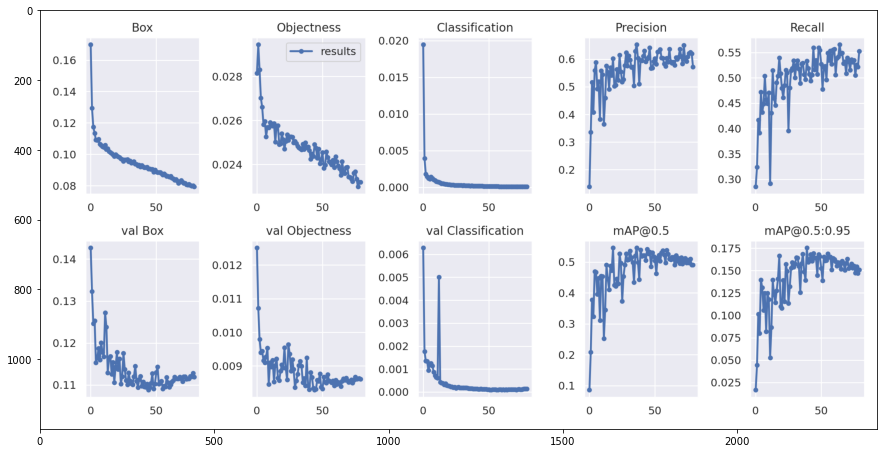

In [63]:
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/results.png'))

## Get the best mAP and best epoch

In [64]:
!ls

CONTRIBUTING.md  base_dir    models	       test.py	       yolov5l.pt
Dockerfile	 data	     my_data.yaml      train.py
LICENSE		 detect.py   my_hyp.yaml       tutorial.ipynb
README.md	 export.py   requirements.txt  utils
__pycache__	 hubconf.py  runs	       wandb


In [65]:
# Display the contents of the results.txt file

path = f'runs/train/{exp}/results.txt'

!cat $path

      0/79     3.57G    0.1699   0.02815   0.01947    0.2175        16       256    0.1384    0.2853   0.08561   0.01668    0.1427   0.01251  0.006286
      1/79     3.91G    0.1294   0.02945  0.003933    0.1628        17       256    0.3354    0.3241    0.2083   0.04463    0.1323   0.01072  0.001771
      2/79     3.91G    0.1174   0.02831  0.001773    0.1475        17       256    0.5162    0.4172    0.3779    0.1014    0.1246  0.009794  0.001347
      3/79     3.91G    0.1135   0.02702  0.001457    0.1419        18       256    0.4078    0.3914    0.3229   0.07989    0.1253  0.009403  0.001345
      4/79     3.91G    0.1091    0.0266  0.001203    0.1369        21       256    0.5585    0.4716    0.4698    0.1395    0.1153  0.009437 0.0009376
      5/79     3.91G    0.1089   0.02582  0.001146    0.1358        14       256     0.588    0.4319    0.4669    0.1308    0.1165  0.009161  0.001191
      6/79     3.91G    0.1096   0.02596  0.001424     0.137        18       256    0.4918    

In [66]:
# Read the results from the training log: results.txt

# https://stackoverflow.com/questions/3277503/how-to-read-a-file-line-by-line-into-a-list
# https://stackoverflow.com/questions/65381312/how-to-convert-a-yolo-darknet-format-into-csv-file


filename = f'runs/train/{exp}/results.txt'

file_list = []

with open(filename) as f:
    # read a line into a list, format: ['item item item', 'item item item', ...]
    file_line_list = f.readlines()
    
    
for i in range(0, len(file_line_list)):
    
    # Get the first item in the list and split on the spaces.
    # This returns a list of all items in the line: ['item', 'item', 'item']
    line_list = file_line_list[i].split()
    
    # remove whitespace characters like `\n` at the end of each line
    line_list = [x.strip() for x in line_list]
    
    # Save the list.
    # all_lines_list is a list of lists
    file_list.append(line_list)
    
len(file_list)

80

In [67]:
# Put the file data into a dataframe

df = pd.DataFrame(file_list)

df.head(10)

0      1       2        3         4       5   6    7       8       9   \
0  0/79  3.57G  0.1699  0.02815   0.01947  0.2175  16  256  0.1384  0.2853   
1  1/79  3.91G  0.1294  0.02945  0.003933  0.1628  17  256  0.3354  0.3241   
2  2/79  3.91G  0.1174  0.02831  0.001773  0.1475  17  256  0.5162  0.4172   
3  3/79  3.91G  0.1135  0.02702  0.001457  0.1419  18  256  0.4078  0.3914   
4  4/79  3.91G  0.1091   0.0266  0.001203  0.1369  21  256  0.5585  0.4716   
5  5/79  3.91G  0.1089  0.02582  0.001146  0.1358  14  256   0.588  0.4319   
6  6/79  3.91G  0.1096  0.02596  0.001424   0.137  18  256  0.4918  0.4483   
7  7/79  3.91G  0.1066  0.02526  0.001207   0.133  18  256  0.5193  0.5034   
8  8/79  3.91G  0.1058  0.02568  0.001049  0.1325  20  256  0.3819  0.4569   
9  9/79  3.91G   0.105  0.02567  0.000936  0.1316  23  256  0.5582  0.4491   

        10       11      12        13         14  
0  0.08561  0.01668  0.1427   0.01251   0.006286  
1   0.2083  0.04463  0.1323   0.01072   0.001771  
2   0.3779   0.1014  0.1246  0.009794   0.001347  
3   0.3229  0.07989  0.1253  0.009403   0.001345  
4   0.4698   0.1395  0.1153  0.009437  0.0009376  
5   0.4669   0.1308  0.1165  0.009161   0.001191  
6   0.3958   0.1058  0.1187  0.009097    0.00125  
7   0.4478   0.1248   0.116  0.009272   0.001136  
8   0.3105  0.08185  0.1201  0.009531  0.0008733  
9   0.4551   0.1248  0.1178  0.008455   0.000711

In [68]:
# choose only the columns we want

col_names = ['epoch', 'P', 'R', 'map0.5', 'map0.5:0.95']

# filter out specific columns
df_results = df[[0, 8, 9, 10, 11]]

df_results.columns = col_names

# change the column names
df_results.head(10)

epoch       P       R   map0.5 map0.5:0.95
0  0/79  0.1384  0.2853  0.08561     0.01668
1  1/79  0.3354  0.3241   0.2083     0.04463
2  2/79  0.5162  0.4172   0.3779      0.1014
3  3/79  0.4078  0.3914   0.3229     0.07989
4  4/79  0.5585  0.4716   0.4698      0.1395
5  5/79   0.588  0.4319   0.4669      0.1308
6  6/79  0.4918  0.4483   0.3958      0.1058
7  7/79  0.5193  0.5034   0.4478      0.1248
8  8/79  0.3819  0.4569   0.3105     0.08185
9  9/79  0.5582  0.4491   0.4551      0.1248

In [69]:
# Get the best map0.5

best_map = df_results['map0.5'].max()

print('---------------------')

print('Best map0.5:', best_map)
print()

# print the row that contains the best map0.5
df = df_results[df_results['map0.5'] == best_map]

print(df.head())

print('---------------------')

---------------------
Best map0.5: 0.5461

    epoch       P       R  map0.5 map0.5:0.95
18  18/79  0.6022  0.5397  0.5461      0.1664
---------------------


## Display one batch of train images

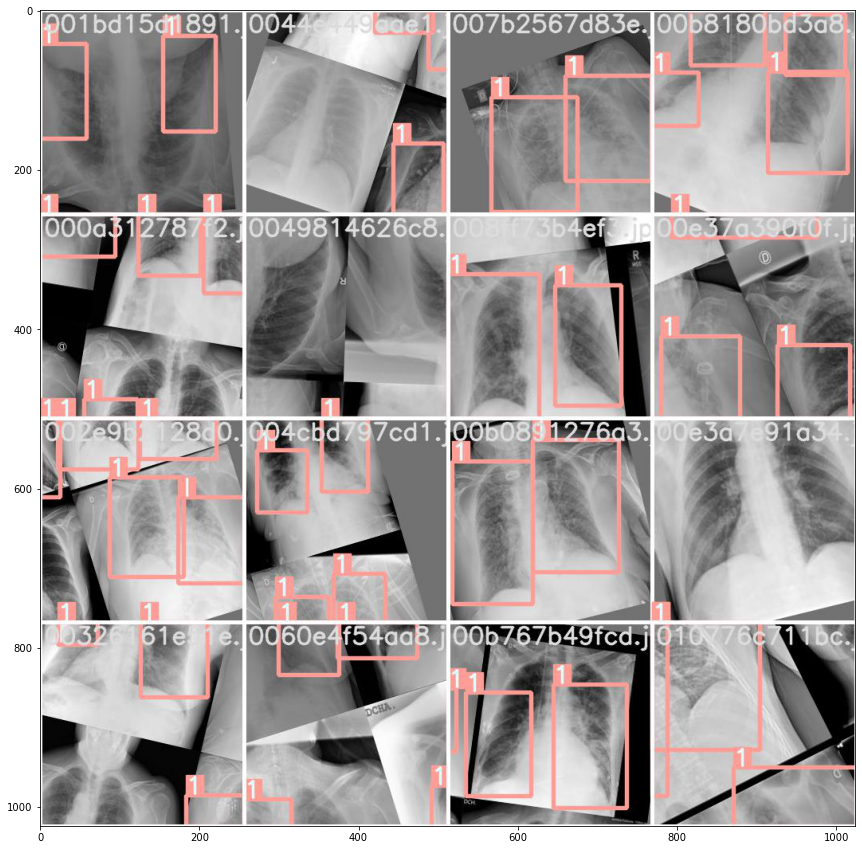

In [70]:
# Train
# One mosaic batch of train images with labels

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/train_batch0.jpg'))

## Display true and predicted val set bboxes

Here we will display the true and predicted bboxes for two val batches.

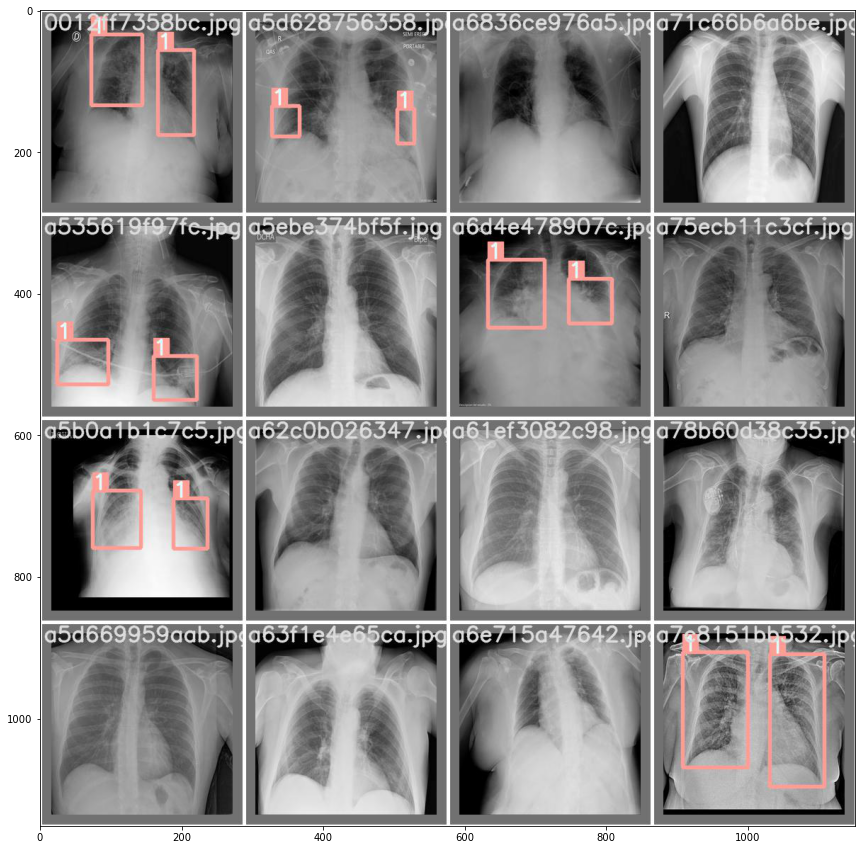

In [71]:
# BATCH 0 - TRUE BBOXES

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/test_batch0_labels.jpg'))

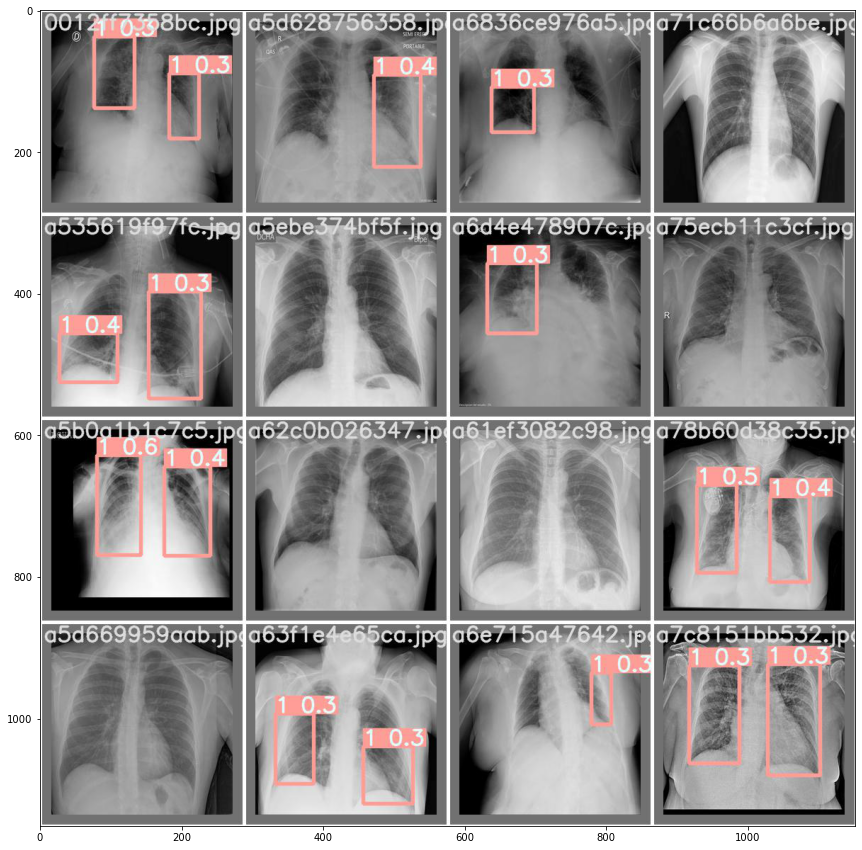

In [72]:
# BATCH 0 - PREDICTED BBOXES

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/test_batch0_pred.jpg'))

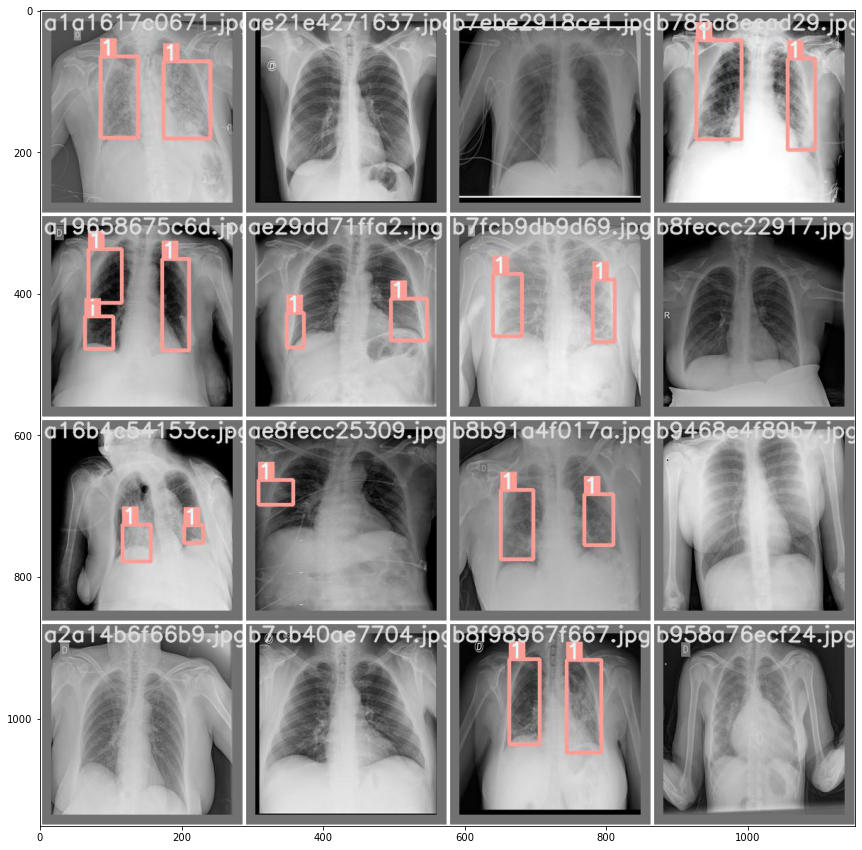

In [73]:
# BATCH 1 - TRUE BBOXES

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/test_batch1_labels.jpg'))

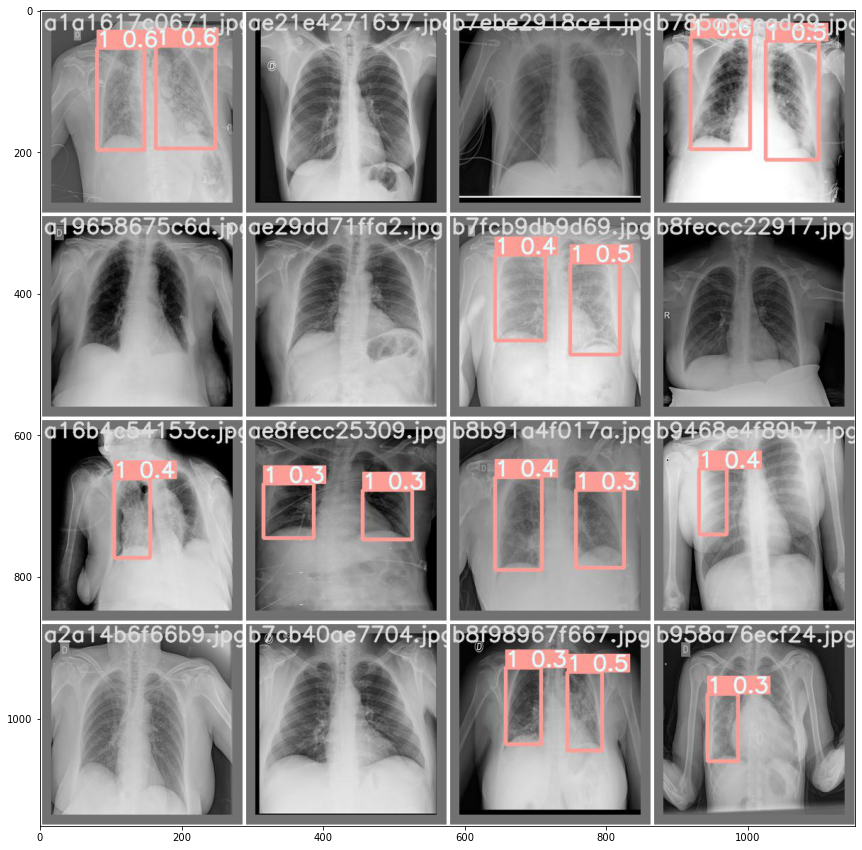

In [74]:
# BATCH 1 - PREDICTED BBOXES

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/test_batch1_pred.jpg'))

## Make a prediction on the val set

In [75]:
# change the working directory
os.chdir('/kaggle/working')

!pwd

/kaggle/working


In [76]:
def set_image_fname(x):
    
    image_fname = x.split('.')[0] + '.jpg'
    
    return image_fname

df_val['image_fname'] = df_val['fname'].apply(set_image_fname)

print(df_val.shape)

#df_val.head()

(1128, 23)


In [77]:
# Create a folder to store the extracted files
if os.path.isdir('yolo_images_dir') == False:
    yolo_images_dir = 'yolo_images_dir'
    os.mkdir(yolo_images_dir)
    
    
    
val_fname_list = list(df_val['image_fname'])

for fname in val_fname_list:

    # Copy the image to images
    shutil.copyfile(
        f"images_dir/{fname}",
       f"yolo_images_dir/{fname}")
    
    
len(os.listdir('yolo_images_dir'))

1128

In [78]:
!ls

__notebook__.ipynb  best.pt  images_dir  yolo_images_dir  yolov5


In [79]:
# change the working directory
os.chdir('/kaggle/working/yolov5')

!pwd

/kaggle/working/yolov5


In [80]:
# Make a prediction on all images in images_dir

# The model only creates a txt file if it finds objects on an image.

test_images_path = '/kaggle/working/yolo_images_dir'
yolo_model_path = '/kaggle/working/best.pt'

# Ensembling two Yolo models
# How to ensemble Yolov5 models:
# Ref: https://github.com/ultralytics/yolov5/issues/318

!python detect.py --source $test_images_path --weights $yolo_model_path --img 256 --save-txt --save-conf --exist-ok

detect: weights=['/kaggle/working/best.pt'], source=/kaggle/working/yolo_images_dir, imgsz=256, conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False
image 1/1128 /kaggle/working/yolo_images_dir/000c3a3f293f.jpg: 256x256 Done. (0.021s)
image 2/1128 /kaggle/working/yolo_images_dir/0012ff7358bc.jpg: 256x256 2 1s, Done. (0.023s)
image 3/1128 /kaggle/working/yolo_images_dir/0023f02ae886.jpg: 256x256 Done. (0.024s)
image 4/1128 /kaggle/working/yolo_images_dir/006e2ac85d57.jpg: 256x256 2 1s, Done. (0.021s)
image 5/1128 /kaggle/working/yolo_images_dir/007cf31356c6.jpg: 256x256 2 1s, Done. (0.023s)
image 6/1128 /kaggle/working/yolo_images_dir/010433f32857.jpg: 256x256 Done. (0.021s)
image 7/1128 /kaggle/working/yolo_images_dir/0124f624dacb.jpg:

## Process the predictions

In [81]:
txt_files_list = os.listdir('runs/detect/exp/labels')

len(txt_files_list)

549

In [82]:
# Put the info inside all the txt files into one dataframe.
# Remember that if the image does not have any bounding boxes
# then Yolo does not create a txt file for it.

txt_files_list = os.listdir('runs/detect/exp/labels')

for i, txt_file in enumerate(txt_files_list):
    
    # set the path
    path = f'runs/detect/exp/labels/{txt_file}'
    
    # create a list of column names
    cols = ['class', 'x-center', 'y-center', 'bbox_width', 'bbox_height', 'conf-score']

    # put the file contents into a dataframe
    df = pd.read_csv(path, sep=" ", header=None)
    
    # add the column names to the datafrae
    df.columns = cols
    
    # Split the txt fname on the full stop and choose the first item 
    # in the list. The add the .jpg extension.
    # 87a0829f53c1.txt becomes 87a0829f53c1_image
    fname = txt_file.split('.')[0] + '.jpg'
    
    # add a new column with the fname
    df['id'] = fname
 
    # stack the dataframes for each txt file
    if i == 0:
        
        df_test_preds = df
    else:
        
        df_test_preds = pd.concat([df_test_preds, df], axis=0)
       
    
    
print(len(txt_files_list))
print(df_test_preds['id'].nunique())
print(df_test_preds.shape)

df_test_preds.head()

549
549
(910, 7)


class  x-center  y-center  bbox_width  bbox_height  conf-score  \
0      1  0.269531  0.339844    0.179688     0.359375    0.318499   
0      1  0.332031  0.572266    0.257812     0.332031    0.272603   
1      1  0.710938  0.431641    0.265625     0.582031    0.416749   
0      1  0.763672  0.462891    0.308594     0.480469    0.328312   
1      1  0.285156  0.402344    0.312500     0.546875    0.413169   

                 id  
0  e5ffb49e8255.jpg  
0  4254395bc50a.jpg  
1  4254395bc50a.jpg  
0  5d252a9ba2f5.jpg  
1  5d252a9ba2f5.jpg

In [83]:
# Add the predictions to df_val

val_pred_list = []

pred_list = list(df_test_preds['id'])

for i in range(0, len(df_val)):
    
    fname = df_val.loc[i, 'image_fname']
    
    if fname in pred_list:
        
        val_pred_list.append(1)
    else:
        val_pred_list.append(0)
    
    
df_val['preds'] = val_pred_list
    
df_val['preds'].value_counts()

0    579
1    549
Name: preds, dtype: int64

## Confusion Matrix

In [84]:
from sklearn.metrics import confusion_matrix

CLASS_LIST = ['Negative for pneumonia', 'Typical']
    
# targets
y_true = list(df_val['target'])

# get the preds as integers
y_pred = list(df_val['preds'])

# argmax returns the index of the max value in each row.
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix.
print()
print(cm)
print(CLASS_LIST)


[[482  82]
 [ 97 467]]
['Negative for pneumonia', 'Typical']


Confusion matrix, without normalization
[[482  82]
 [ 97 467]]


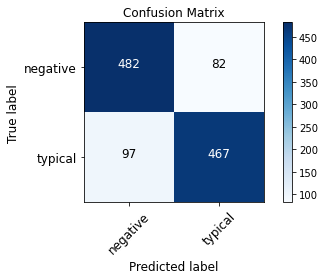

In [85]:
cm_plot_labels = ['negative', 'typical']

# Set the size of the plot.
#plt.figure(figsize=(10,7))

# Set the size of the text
text_size=12

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', text_size=text_size)

## Classification Report

In [86]:
from sklearn.metrics import classification_report
    
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print()
print(report)


              precision    recall  f1-score   support

    negative       0.83      0.85      0.84       564
     typical       0.85      0.83      0.84       564

    accuracy                           0.84      1128
   macro avg       0.84      0.84      0.84      1128
weighted avg       0.84      0.84      0.84      1128



## Save the train and val dataframes

In [87]:
# Save df_train and df_val for model analysis later.
path = 'df_train.csv'
df_train.to_csv(path, index=False)

path = 'df_val.csv'
df_val.to_csv(path, index=False)

## Save the val images

We can use these later to check the app

In [88]:
# change the working directory
os.chdir('/kaggle/working/')

!pwd

/kaggle/working


In [89]:
# Create a new directory
val_images_dir = 'val_images_dir'
os.mkdir(val_images_dir)

In [90]:
# Copy the val images into val_images_dir

val_image_list = list(df_val['fname'])

for fname in val_image_list:

    image_id = fname.split('.')[0]
    fname = image_id + '.jpg'

    src = f'images_dir/{fname}'
    dst = f'val_images_dir/{fname}'

    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [91]:
# Check that the images have been copied

len(os.listdir('val_images_dir'))

1128

In [92]:
# Compress the folders so they can appear
# in the notebook output.

!tar -zcf val_images.tar.gz -C "val_images_dir/" .

In [93]:
!ls

__notebook__.ipynb  images_dir	       val_images_dir	yolov5
best.pt		    val_images.tar.gz  yolo_images_dir


## Delete images to prevent notebook commit errors

In [94]:
# change the working directory to yolov5

os.chdir('/kaggle/working/yolov5')

!pwd

/kaggle/working/yolov5


In [95]:
# Delete the folder to prevent a Kaggle error.

if os.path.isdir('base_dir') == True:
    shutil.rmtree('base_dir')

In [96]:
# change the working directory

os.chdir('/kaggle/working/')

!pwd

/kaggle/working


In [97]:
# Delete the folder to prevent a Kaggle error.

if os.path.isdir('images_dir') == True:
    shutil.rmtree('images_dir')
    
if os.path.isdir('masks_dir') == True:
    shutil.rmtree('masks_dir')
    
if os.path.isdir('val_images_dir') == True:
    shutil.rmtree('val_images_dir')

In [98]:
!ls

__notebook__.ipynb  best.pt  val_images.tar.gz	yolo_images_dir  yolov5
